In [1]:
import pandas as pd
import numpy as np
from openeye import oechem, oedepict, oemolprop
import oenotebook as oenb
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Import output dataframe of XlogP_and_mw_filter.ipynb
df_mw= pd.read_csv("df_mw.csv")
df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.480,253.296,100.0,168.0,fragment-like


## 3. Filtering based on number of rotatable bonds

In [3]:
# Number of non-terminal rotatable bonds (excluding -OH)

df_mw["N_Rot"]=None

for i, row in enumerate(df_mw.iterrows()):
    smiles = df_mw.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, smiles)
    
    rotcounts = []
    nrots = oechem.OECount(mol, oechem.OEIsRotor())
    while nrots >= len(rotcounts):
        rotcounts.append(0)
    rotcounts[nrots] += 1
    
    del mol
    number_of_rotatable_bonds = len(rotcounts) - 1
    #print ("Max rotors:", number_of_rotatable_bonds)
    #print(df_mw.loc[i,"eMolecules ID"])
    
    df_mw.loc[i,"N_Rot"]= number_of_rotatable_bonds 

df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like,1
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like,3
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like,2
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like,2
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.480,253.296,100.0,168.0,fragment-like,5


In [4]:
# Number of rotatable bonds in fragment-like group shoud be <= 3
df_frag = df_mw.loc[df_mw["group"] == "fragment-like"]
df_frag_nrot_interval = df_frag.loc[df_frag["N_Rot"] <= 3]

print("Number of compounds suitable for fragment-like group: ", df_frag_nrot_interval.shape[0])

Number of compounds suitable for fragment-like group:  76


## 4. Filtering based on possible UV-chromophores

In [5]:
# For UV-metric pKa measurement UV chromophores absorbing in 200-400 nm are necessary.
# I will use presence of C=C-C=C, C=C-C=O or C=C-C=N  substructures as an indictato of UV-chromophore
# 1.3-butadiene absorbs at 217 nm

df_mw["N_UV_chrom"]=None

UV_chromophore_SMARTS = "[n,o,c][c,n,o]cc"

for i, row in enumerate(df_mw.iterrows()):

    # Count number UV absorbing conjugated-pi systems using SMARTS matching

    smiles = df_mw.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, str(smiles))

    #create a substructure search object
    queried_substructure = UV_chromophore_SMARTS
    ss = oechem.OESubSearch(queried_substructure)
    oechem.OEPrepareSearch(mol, ss)

    # loop over matches to count
    matched_ss_list=[]
    UV_chromophore_count = 0
    for index, match in enumerate(ss.Match(mol)):
        if ss.SingleMatch(mol) == True:
            matched_ss_list.append((index, match))
            UV_chromophore_count = len(matched_ss_list)
    
    df_mw.loc[i, "N_UV_chrom"] = UV_chromophore_count

df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot,N_UV_chrom
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like,1,15
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like,3,41
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like,2,9
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like,2,24
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.480,253.296,100.0,168.0,fragment-like,5,24


In [6]:
df_frag = df_mw.loc[df_mw["group"] == "fragment-like"].reset_index(drop=True)
print("Number of compounds suitable for fragment-like group: ", df_frag.shape[0])

# What is the minimum number of UV-chromophore matches in the drug-like and fragment-like group?
print("Minimum number of UV-chromophore units in fragment-like group: ", min(df_frag["N_UV_chrom"]) )

Number of compounds suitable for fragment-like group:  126
Minimum number of UV-chromophore units in fragment-like group:  8


## 5. Eliminate compounds with NaN price or availability

In [7]:
# Eliminate entries without price in fragment-like set
df_frag = df_frag[np.isfinite(df_frag["Price"])].reset_index(drop=True)

# Eliminate entries with availability less than 100 mg
df_frag = df_frag[df_frag["Availability (mg)"] >= 100.0].reset_index(drop=True)
print("Number of fragment-like molecules with price and 100 mg availability:",df_frag.shape[0])

Number of fragment-like molecules with price and 100 mg availability: 111


## 6. Sort molecules by their price

In [8]:
df_frag = df_frag.sort_values(by = "Price", ascending = True, inplace=False).reset_index(drop=True)

## 7. Eliminate compounds determined to have experimental logP reported

I run cycles of selecting 25 compounds for fragment-like group and checking which ones have experimental logPs reported. eMolecules IDs of compounds with reported logPs were saved in a list, so that we can avoid them.

In [9]:
# List of molecules with experimental logPs reported in Chemspider
list_of_paths_to_exp_logP_file =  [
    "../20170808_zinc15_eMolecules_subset_exp_logP_check/fragments_with_exp_logP_round1.pickle",
    "../20170808_zinc15_eMolecules_subset_exp_logP_check/fragments_with_exp_logP_round2.pickle",
    "../20170808_zinc15_eMolecules_subset_exp_logP_check/fragments_with_exp_logP_round3.pickle",
    "../20170808_zinc15_eMolecules_subset_exp_logP_check/fragments_with_exp_logP_round4.pickle"]

print("Number of molecules before filtering by experimental logP:, ",df_frag.shape[0])

for file in list_of_paths_to_exp_logP_file:
    exp_logP_list = pickle.load(open(file, "rb"))

    print("eMolecules IDs of compounds eliminated:")
    for eMol_id in exp_logP_list:
        print(eMol_id)
        df_frag = df_frag[df_frag["eMolecules ID"] != eMol_id].reset_index(drop=True)

print("Number of molecules after eliminating compounds with experimental logP: ",df_frag.shape[0])

Number of molecules before filtering by experimental logP:,  111
eMolecules IDs of compounds eliminated:
490595
532754
4934119
2867544
2727697
493608
508324
2042282
1698122
703997
eMolecules IDs of compounds eliminated:
45490344
27013168
1503405
17004732
2266357
1202048
3374919
eMolecules IDs of compounds eliminated:
3605943
2546448
1716329
eMolecules IDs of compounds eliminated:
1532460
Number of molecules after eliminating compounds with experimental logP:  90


## 8. Include molecules with ring scaffolds of FDA approved PKIs
Murcko fragments of FDA approved Protein Kinase Inhibitors were created. I analyzed the frequency of appearance of ring fragments. The following rings were seen multiple times:
1. pyridine
2. piperazine
3. quinazoline
4. quinoline
5. pyrimidine
6. indazole
7. pyrazole
8. imidazole

I aim to include at least one molecule of each of these frequent rings in the SAMPL6 fragment-like set.

In [10]:
ring_smarts = {'pyridine':"c1cccc[nX2]1",
               'piperazine': "[NX3]1CC[NX3]CC1",
               'quinazoline': "c:1:c:2:c(:c:c:c:1):n:c:n:c:2",
               'quinoline': "c:1:c:2:c(:c:c:c:1):n:c:c:c:2",
               'pyrimidine': "c1[nX2]ccc[nX2]1",
               'indazole': "c1c2c(ccc1)nnc2",
               'pyrazole': "c1cnnc1",
               'imidazole': "c1nccn1"}

#How to record selected compounds
picked_ids=[]
df_frag["Selection"] = None
df_frag["Bin index"] = None
df_frag["Priority"] = None

# Find the cheapest compound that matches each ring 
for key, value in ring_smarts.items():
    queried_substructure = value
    
    # Iterate over compounds in the increasing price order
    for i, row in df_frag.iterrows():
        smiles = row["canonical isomeric SMILES"]
        
        # Substructure search
        mol = oechem.OEGraphMol()
        oechem.OESmilesToMol(mol, str(smiles))
        ss = oechem.OESubSearch(queried_substructure)
        oechem.OEPrepareSearch(mol, ss)

        # loop over matches to count
        matched_ss_list=[]
        count = 0
        for index, match in enumerate(ss.Match(mol)):
            if ss.SingleMatch(mol) == True:
                matched_ss_list.append((index, match))
                count = len(matched_ss_list)
        
        # If substructure matches and molecule already not selected
        if (count >= 1) and (df_frag.loc[i, "Selection"] != "picked"):
            df_frag.loc[i,"Selection"] = "picked"
            df_frag.loc[i,"Priority"] = 1
            print("Molecule that has {}: {}".format(key, smiles))
            break
 
    # If no match found
    if count == 0:
        print("Could not found a molecule that has {}!".format(key))
 

Molecule that has pyrimidine: COc1cccc(c1)Nc2c3ccccc3ncn2.Cl
Molecule that has pyrazole: c1ccc(cc1)NC(=O)c2c3ccccc3[nH]n2
Could not found a molecule that has piperazine!
Molecule that has imidazole: c1ccc2c(c1)ncn2c3ccc(cc3)O
Molecule that has pyridine: c1cc2cccnc2c(c1)NC(=O)c3cc(cnc3)Br
Molecule that has quinazoline: c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl
Could not found a molecule that has indazole!
Molecule that has quinoline: c1ccc(c(c1)C(=O)Nc2cccc3c2nccc3)Cl


## 9. Limit frequently appearing rings

### Limit multiple compounds with aminothiozole group
Aminothiozole group could be reactive and it is uncommon in medicinal screening libraries. Without this filter they showed up too frequenty in my fragment and drug sets. I will include only 1 molecule with 2-aminothiazole group.

### Limit the other frequent groups
1. thiophene
2. 5-methylenethiazolidine-2,4-dione
3. 1,3,4-thiadiazole

Without this filter they showed up too frequenty in my fragment and drug sets. 
I will select one compound from these groups and eliminate replicates.

In [11]:
ring_smarts_to_limit = {
               'aminothiazole': "[c,C]~1(~[nX2,NX2]~[c,C]~[c,C]~[s,S]~1)[NX3,nX3]",
               'thiophene': "c1cscc1",
               '5-methylenethiazolidine-2,4-dione': "[NX3,nX3]1[c,C]([s,S][c,C]([c,C]1=[O,o])=[C,c])=[O,o]",
               '1,3,4-thiadiazole': "n1:csc:n1"}

# Find the cheapest compound that matches each ring 
for key, value in ring_smarts_to_limit.items():
    queried_substructure = value
    
    # Iterate over compounds in the increasing price order
    for i, row in df_frag.iterrows():
        smiles = row["canonical isomeric SMILES"]
        
        # Substructure search
        mol = oechem.OEGraphMol()
        oechem.OESmilesToMol(mol, str(smiles))
        ss = oechem.OESubSearch(queried_substructure)
        oechem.OEPrepareSearch(mol, ss)

        # loop over matches to count
        matched_ss_list=[]
        count = 0
        for index, match in enumerate(ss.Match(mol)):
            if ss.SingleMatch(mol) == True:
                matched_ss_list.append((index, match))
                count = len(matched_ss_list)
        
        # If substructure matches and molecule already not selected
        if (count >= 1) and (df_frag.loc[i, "Selection"] != "picked"):
            df_frag.loc[i,"Selection"] = "picked"
            df_frag.loc[i,"Priority"] = 1
            print("Molecule that has {}: {}".format(key, smiles))
            break
 
    # If no match found
    if count == 0:
        print("Could not found a molecule that has {}!".format(key))
 

Molecule that has 5-methylenethiazolidine-2,4-dione: c1cc(c(cc1c2ccc(o2)/C=C/3\C(=O)NC(=O)S3)Cl)F
Molecule that has aminothiazole: c1ccc(cc1)C(=O)NCC(=O)Nc2nc3ccccc3s2
Molecule that has 1,3,4-thiadiazole: c1ccc(cc1)Cc2nnc(s2)NC(=O)c3cccs3
Molecule that has thiophene: CC(C)OC(=O)c1c(csc1N)c2ccc(c(c2)OC)OC


## 10. Select molecules for even coverage of logP dynamic range

While selecting from each logP bin, first compounds selected for their ring substructres will be assigned to each bin. Then for selecting more compounds I will prioritize cheaper compounds, based on the price sorted dataframes.

25 fragment-like molecules will be selected.

In [12]:
# Establish dynamic range
XlogPs = np.array(df_frag["XlogP"])

minval = XlogPs.min()
maxval = XlogPs.max()

print("Dynamic range of XlogP is from %.2f to %.2f" % (minval, maxval))

# Let's make 25 bins and try drawing 5 compounds per bin
nbins = 25
n_per_bin = 5 
bin_lefts = np.arange( minval, maxval, (maxval-minval)/float(nbins) )
bin_rights = np.array( [bin_lefts[i+1] for i in range(nbins-1)] + [maxval] )

print("Bin lefts: \n", bin_lefts)
print("Bin rights: \n", bin_rights)

# Place compounds selected for their substructures to correponding bins
range_ids = []
for i, row in df_frag.iterrows():
    
    # Iterate over selected compounds
    if df_frag.loc[i, "Selection"] == "picked":
        eMolecules_ID = df_frag.loc[i,'eMolecules ID'] #identifier
        XlogP = float(df_frag.loc[i,'XlogP'])
        
        # iterate over bins to find the right bin
        for bin_index in range(nbins):
            # how many compounds are in that bin so far?
            fnd_in_bin = df_frag.loc[df_frag["Bin index"]== bin_index].shape[0]
            
            if (XlogP > bin_lefts[bin_index]) and (XlogP <= bin_rights[bin_index]):
                range_ids.append( eMolecules_ID )
                fnd_in_bin +=1
                df_frag.loc[i, "Bin index"] = bin_index
                df_frag.loc[i, "Priority"] = fnd_in_bin
                print("Molecule {} is already selected from bin {}.".format(eMolecules_ID, bin_index))

print("Selecting more compounds from each bin...")

# Select more compound from each bin
for bin_index in range(nbins):
    
    # how many compounds are in that bin so far?
    fnd_in_bin = df_frag.loc[df_frag["Bin index"]== bin_index].shape[0]
    
    for i, row in enumerate(df_frag.iterrows()):
        eMolecules_ID = df_frag.loc[i,'eMolecules ID'] #identifier
        XlogP = float(df_frag.loc[i,'XlogP'])
        
        if (XlogP > bin_lefts[bin_index]) and (XlogP <= bin_rights[bin_index]) and (df_frag.loc[i, "Selection"] != "picked"):
            
            # Skip molecule if it has a limited ring group, because we have already picked one.
            # substructure search
            count = 0
            for ring, smarts in ring_smarts_to_limit.items(): 
            
                smiles = df_frag.loc[i,'canonical isomeric SMILES']
                mol = oechem.OEGraphMol()
                oechem.OESmilesToMol(mol, str(smiles))

                queried_substructure = smarts
                ss = oechem.OESubSearch(queried_substructure)
                oechem.OEPrepareSearch(mol, ss)

                # loop over matches to count
                matched_ss_list=[]
                for index, match in enumerate(ss.Match(mol)):
                    if ss.SingleMatch(mol) == True:
                        matched_ss_list.append((index, match))
                        count = count + len(matched_ss_list) 
                    
            # skip the molecule if one of the limited substructes exists in the molecule
            if count >= 1:
                continue
                
            # Pick the compound
            range_ids.append( eMolecules_ID )
            fnd_in_bin +=1
            
            df_frag.loc[i, "Selection"] = "picked"
            df_frag.loc[i, "Bin index"] = bin_index
            df_frag.loc[i, "Priority"] = fnd_in_bin
                

        if fnd_in_bin == n_per_bin: break

    if fnd_in_bin < n_per_bin:
        print ("Can't find %s molecules in bin %s. Only %s molecule(s) found." % (n_per_bin, bin_index, fnd_in_bin) )


print("Found %s compounds spanning the dynamic range, out of %s desired. " % (len(range_ids), nbins*n_per_bin) )

Dynamic range of XlogP is from -0.07 to 4.79
Bin lefts: 
 [-0.07300001  0.12132     0.31564001  0.50996003  0.70428004  0.89860005
  1.09292007  1.28724008  1.48156009  1.67588011  1.87020012  2.06452013
  2.25884015  2.45316016  2.64748018  2.84180019  3.0361202   3.23044022
  3.42476023  3.61908024  3.81340026  4.00772027  4.20204028  4.3963603
  4.59068031]
Bin rights: 
 [ 0.12132     0.31564001  0.50996003  0.70428004  0.89860005  1.09292007
  1.28724008  1.48156009  1.67588011  1.87020012  2.06452013  2.25884015
  2.45316016  2.64748018  2.84180019  3.0361202   3.23044022  3.42476023
  3.61908024  3.81340026  4.00772027  4.20204028  4.3963603   4.59068031
  4.78500032]
Molecule 1228629 is already selected from bin 18.
Molecule 1865544 is already selected from bin 16.
Molecule 23354217 is already selected from bin 14.
Molecule 18893169 is already selected from bin 15.
Molecule 30719859 is already selected from bin 18.
Molecule 37095168 is already selected from bin 11.
Molecule 2577

(0, 10)

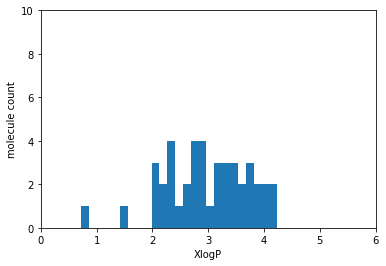

In [13]:
df_frag_picked = df_frag.loc[df_frag["Selection"]=="picked"].reset_index(drop=True)
df_frag_picked.to_csv("df_frag_picked.csv")

# Let's check the logP distribution of fragment-like group
XlogP_values = df_frag_picked.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=nbins)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [14]:
# Pick cheapest 25 molecules

# Sort selected molecules by bin index
df_frag_picked = df_frag_picked.sort_values(by = ["Bin index", "Price"], ascending = [True, True], inplace=False)
df_frag_picked.head(10)

# Select 25 cheapest compounds with even bin distribution
df_frag_picked["Final list"] = None

molecules_added_to_set = 0

# In first pass select the cheapest molecule in each bin
for bin_index in range(nbins):
    df_bin = df_frag_picked[df_frag_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if molecules_added_to_set == 25:
        break
    else:

        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] >= 1:
            #select the cheapest molecule
            molecules_added_to_set += 1
            eMol_ID = df_bin.loc[0, "eMolecules ID"] # 1st cheapest molecule
            df_frag_picked.loc[df_frag_picked["eMolecules ID"] == eMol_ID, "Final list"] = True
        
# In the second pass select the next cheapest un selected molecule in each bin
for bin_index in range(nbins):
    df_bin = df_frag_picked[df_frag_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if molecules_added_to_set == 25:
        break
    else:
        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
        
        elif df_bin.shape[0] == 1:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] > 1:
            #select the next cheapest molecule
            molecules_added_to_set += 1
            eMol_ID = df_bin.loc[1, "eMolecules ID"] # 2nd cheapest molecule
            df_frag_picked.loc[df_frag_picked["eMolecules ID"] == eMol_ID, "Final list"] = True

# In the third pass select the next cheapest unselected molecule in each bin
for bin_index in range(nbins):
    df_bin = df_frag_picked[df_frag_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if molecules_added_to_set == 25:
        break
    else:
        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
        
        elif df_bin.shape[0] == 1:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] > 1:
            #select the next cheapest molecule
            molecules_added_to_set += 1
            eMol_ID = df_bin.loc[2, "eMolecules ID"] # 2nd cheapest molecule
            df_frag_picked.loc[df_frag_picked["eMolecules ID"] == eMol_ID, "Final list"] = True

# 11. Replacing unavailable molecule
N-phenyl-1H-indazole-3-carboximide was not available for 2 week delivery, 
so we also have to eliminate that molecule and pick another molecule. Since 
there is no other available molecule in bin 13, one will be picked from bin 11.

In [15]:
# Drop the unavailable molecule from final list
smiles_of_unavailable_molecule="c1ccc(cc1)NC(=O)c2c3ccccc3[nH]n2"
eMol_ID = 13419113
df_frag_picked.loc[df_frag_picked["eMolecules ID"] == eMol_ID, "Final list"] = None
df_frag_final = df_frag_picked[df_frag_picked["Final list"] == True].reset_index(drop=True)
print("Number of selected fragment-like molecules after removing unavailable molecule:",df_frag_final.shape[0])

Number of selected fragment-like molecules after removing unavailable molecule: 24


In [16]:
# Pick another compound from bin 15
# df_frag_picked.loc[df_frag_picked["eMolecules ID"] == 1284691,"Final list"] = True
# df_frag_picked[df_frag_picked["eMolecules ID"] == 1284691]

In [17]:
# Pick a unused compound from bin 15
bin_index=15
df_bin = df_frag_picked[df_frag_picked["Bin index"] == bin_index].reset_index(drop=True)
print("Number of molecules in bin ",bin_index,": ", df_bin.shape[0])

eMol_ID = df_bin.loc[2, "eMolecules ID"] # 4rd cheapest molecule: first 2 were already selected
print("eMolecules ID of selected replacement molecule: ", eMol_ID)

df_frag_picked.loc[df_frag_picked["eMolecules ID"] == eMol_ID, "Final list"] = True

Number of molecules in bin  15 :  4
eMolecules ID of selected replacement molecule:  1284691


In [18]:
df_frag_final = df_frag_picked[df_frag_picked["Final list"] == True].reset_index(drop=True)
print("Number of selected fragment-like molecules:",df_frag_final.shape[0])

Number of selected fragment-like molecules: 25


,Molecule
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,

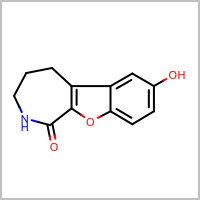
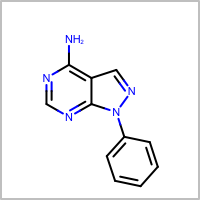
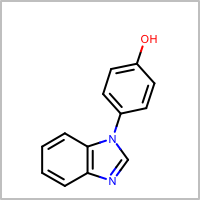
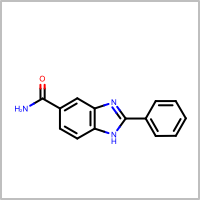
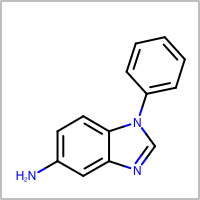
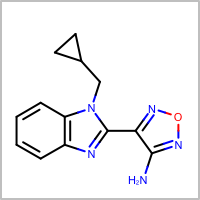
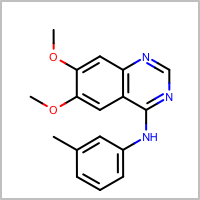
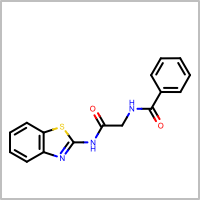
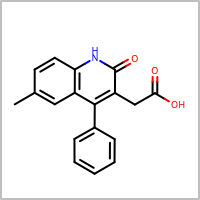
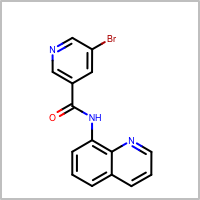
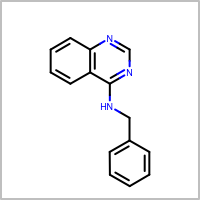
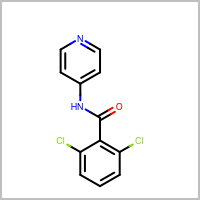
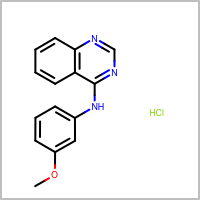
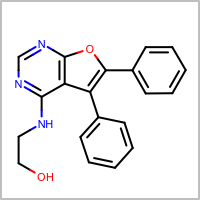
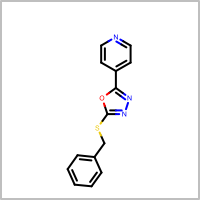
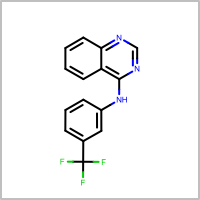
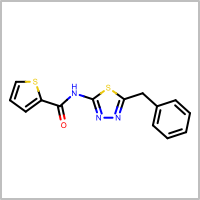
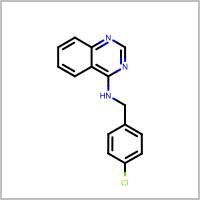
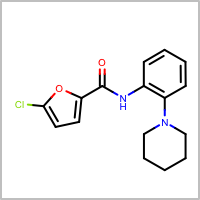
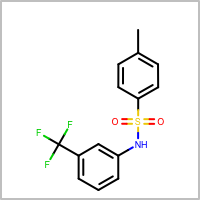
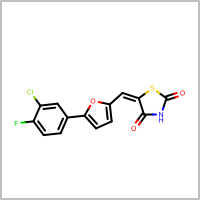
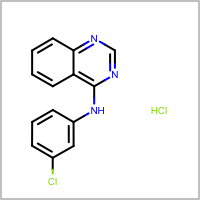
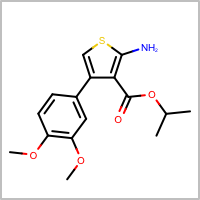
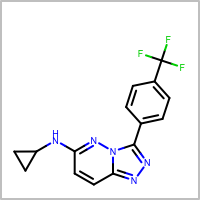
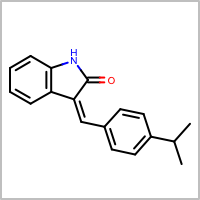

In [22]:
# Import database as eonb for visualization
frag_final_smiles = df_frag_final.loc[:,"canonical isomeric SMILES"].tolist()
#print("Number of molecules: ", len(frag_final_smiles))

file_name = "frag_final.smi"
writer = open(file_name, "w")

for smiles in frag_final_smiles:
    writer.write("%s\n" %smiles)

df_frag_final_oenb = oenb.read_file_to_dataframe(filename="frag_final.smi")
oenb.render_dataframe(df_frag_final_oenb, width=200, height=200)

(0, 10)

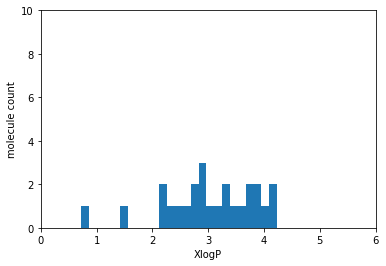

In [20]:
# Let's check the logP distribution of final fragment-like group
df_frag_final = df_frag_picked[df_frag_picked["Final list"] == True].reset_index(drop=True)
df_frag_final.to_csv("df_frag_final.csv", index = False)

XlogP_values = df_frag_final.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=nbins)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [21]:
df_frag_final

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot,N_UV_chrom,Selection,Bin index,Priority,Final list
0,6679830,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,Oc1cc2c3CCCNC(=O)c3oc2cc1,[9.119],0.720,217.221,184.0,533.0,fragment-like,0,27,picked,4,1,True
1,719540,c1ccc(cc1)n2c3c(cn2)c(ncn3)N,Nc1ncnc2c1cnn2c1ccccc1,[3.869],1.499,211.223,3430.0,414.0,fragment-like,1,31,picked,8,1,True
2,37095168,c1ccc2c(c1)ncn2c3ccc(cc3)O,Oc1ccc(cc1)n1cnc2c1cccc2,"[5.82, 8.709]",2.219,210.231,21650.2,148.0,fragment-like,1,40,picked,11,1,True
3,37053191,c1ccc(cc1)c2[nH]c3ccc(cc3n2)C(=O)N,NC(=O)c1ccc2c(c1)nc([nH]2)c1ccccc1,[6.342],2.192,237.257,2000.0,168.0,fragment-like,2,42,picked,11,2,True
4,31653344,c1ccc(cc1)n2cnc3c2ccc(c3)N,Nc1ccc2c(c1)ncn2c1ccccc1,[6.348],2.333,209.247,50213.0,148.0,fragment-like,1,40,picked,12,1,True
5,8332960,c1ccc2c(c1)nc(n2CC3CC3)c4c(non4)N,Nc1nonc1c1nc2c(n1CC1CC1)cccc2,[4.082],2.440,255.275,300.0,168.0,fragment-like,3,28,picked,12,2,True
6,5828805,Cc1cccc(c1)Nc2c3cc(c(cc3ncn2)OC)OC,COc1cc2c(ncnc2cc1OC)Nc1cccc(c1)C,[4.267],2.595,295.336,1864.0,414.0,fragment-like,4,36,picked,13,2,True
7,23354217,c1ccc(cc1)C(=O)NCC(=O)Nc2nc3ccccc3s2,O=C(Nc1nc2c(s1)cccc2)CNC(=O)c1ccccc1,[8.672],2.718,311.358,149.1,148.0,fragment-like,6,28,picked,14,1,True
8,1367649,Cc1ccc2c(c1)c(c(c(=O)[nH]2)CC(=O)O)c3ccccc3,OC(=O)Cc1c(=O)[nH]c2c(c1c1ccccc1)cc(cc2)C,[4.109],2.803,293.317,232.1,223.0,fragment-like,3,59,picked,14,2,True
9,18893169,c1cc2cccnc2c(c1)NC(=O)c3cc(cnc3)Br,Brc1cncc(c1)C(=O)Nc1cccc2c1nccc2,"[4.001, 10.328]",2.923,328.163,406.0,148.0,fragment-like,3,37,picked,15,1,True
